#### Импорт необходимых объектов

In [1]:
import os
import csv
import numpy as np
from scipy.interpolate import splrep, splev
import pickle

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Lars, LarsCV
from sklearn.linear_model import LassoLars, LassoLarsCV
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Сумма, средний, высший, низший уровни

In [3]:
def get_sum(h_max):
    return np.sum(h_max)
    
def get_avg(h_max):
    return np.mean(h_max)
    
def get_max(h_max):
    return np.amax(h_max)
    
def get_min(h_max):
    return np.amin(h_max)

#### Среднеквадратическая погрешность прогноза S

In [4]:
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [5]:
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Среднее значение максимальных уровней воды

In [6]:
def get_hmax_avg(h_max):
    # Среднее значение h_max.
    # Рассчитывается только по всей совокупности данных.
    return np.mean(h_max)

#### Допустимая погрешность прогноза delta_dop

In [7]:
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [8]:
def get_criterion(s, sigma):
    return s / sigma

#### Климатическая обеспеченность Pk

In [9]:
def get_pk(h_max, h_max_avg, delta_dop):
    diff = np.abs(h_max - h_max_avg) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Обеспеченность метода (оправдываемость) Pm

In [10]:
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [11]:
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Вероятная ошибка прогноза S'

In [12]:
def get_forecast_error(s):
    return 0.674 * s

#### Ошибки климатического/природного прогноза для каждого года delta50

In [13]:
def get_delta50(h_max, delta_dop, h_max_avg=None, h_max_forecast=None):
    if h_max_forecast is None:
        # delta50 климатическая
        return (h_max - h_max_avg) / delta_dop
    else:
        # delta50 прогноза
        return (h_max - h_max_forecast) / delta_dop
  

#### Функция записи списка моделей с их характеристиками в csv файл

In [14]:
def write_dataset_csv(year, dataset, dataset_name, fieldnames, pr_group, mode='training'):
    if mode == 'estimation':
        dir_path = f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/'
        file_name = f'{dataset_name}-гр{pr_group}-Оценка.csv'
    elif mode == 'training':
        dir_path = f'results/Models/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Обучение.csv'
    elif mode == 'forecast':
        dir_path = f'results/Forecast/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Прогноз.csv'
    else:
        ...
    
    with open(
        f'{dir_path}'
        f'{file_name}', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция записи результатов экспериментов в csv файл для процесса выбора моделей и параметров

In [15]:
def write_experiment_csv(year, dataset, fieldnames, filename):
    fpath = f'results/Estimation/{year}/{filename}.csv'
    with open(fpath, 'a', newline='') as csvfile: #, encoding='cp1251'
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        fsize = os.stat(fpath).st_size
        if not fsize:
            writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [16]:
def train_test_split(X, y, n_test, split=True):
    if split:   
        X_train = X[:-n_test].copy()
        y_train = y[:-n_test].copy()
        X_test = X[-n_test:].copy()
        y_test = y[-n_test:].copy()
    else:
        X_train = X.copy()
        y_train = y.copy()
        X_test = X.copy()
        y_test = y.copy()
    return X_train, y_train, X_test, y_test

#### Функция перемешивания данных

In [17]:
def shuffle_xy(X, y, shuffle=True):
    if shuffle:
        # Перемешивание данных
        Xy = np.column_stack((X, y))
        rng = np.random.default_rng(42)
        rng.shuffle(Xy)
        y_sh = Xy[:, -1]
        X_sh = Xy[:,:-1]
    else:
        y_sh = y.copy()
        X_sh = X.copy()
    return X_sh, y_sh

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [18]:
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [19]:
def get_datasets():
    datasets = {
        'Неман-Белица': 'Неман',
        'Неман-Гродно': 'Неман',
        'Неман-Мосты': 'Неман',
        'Неман-Столбцы': 'Неман',

        'Вилия-Стешицы': 'Вилия',
        'Вилия-Михалишки': 'Вилия',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [20]:
def get_predictors(dataset_name, group=None):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        ),
        'Вилия': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'],
        )
    }
    result = predictors_lists[datasets[dataset_name]] if group is None else \
             predictors_lists[datasets[dataset_name]][group]
    return result
    

#### Функция получения нормированных значений предикторов

In [21]:
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'X1': 43.0, 'X2':34.0},

        'Вилия-Стешицы': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0},
        'Вилия-Михалишки': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [22]:
def augment_data(x_data, y_data, aug_n, aug_pow=2, mirror=True, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
        
    # # --------- Умножение на коэфф, без mirror!
    # x_augmented_dif = (x_augmented - np.mean(x_augmented)) * 0.25
    # y_augmented_dif = (y_augmented - np.mean(y_augmented)) * 0.25
    
    # x_augmented_up = x_augmented + x_augmented_dif
    # x_augmented_dn = x_augmented - x_augmented_dif
    # y_augmented_up = y_augmented + y_augmented_dif
    # y_augmented_dn = y_augmented - y_augmented_dif

    # x_augmented = np.vstack((x_augmented_up, x_augmented_dn))
    # y_augmented = np.hstack((y_augmented_up, y_augmented_dn))

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented_up, y_points_n, y_augmented_dn)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented_up[:, 0], x_points_n, x_augmented_dn[:, 0])
    # # -----------
    
    x_aug_round = np.round(x_augmented, decimals=-1)
    y_aug_round = np.round(y_augmented, decimals=1)

    x_data_round = np.round(x_data, decimals=-1)
    y_data_round = np.round(y_data, decimals=1)   

    # x_aug_round = np.trunc(x_augmented)
    # y_aug_round = np.trunc(y_augmented)

    # x_data_round = np.trunc(x_data)
    # y_data_round = np.trunc(y_data)   

    
    
    mx = (x_aug_round[:, None] == x_data_round).all(-1).any(1)
    x_aug_clear = x_augmented[~mx].copy()
    y_aug_clear = y_augmented[~mx].copy()
    points_aug_clear = y_points_n[~mx]
    
    # my = np.in1d(y_aug_round, y_data_round)
    # x_aug_clear = x_aug_clear[~my]
    # y_aug_clear = y_aug_clear[~my]
    
    print('x_aug_clear.shape', x_aug_clear.shape)
    print('x_augmented.shape', x_augmented.shape)

    if mirror:
        x_mirror = np.mean(x_augmented) - x_augmented + np.mean(x_augmented)
        y_mirror = np.mean(y_augmented) - y_augmented + np.mean(y_augmented)
    
        x_result = np.vstack((x_aug_clear, x_mirror))
        y_result = np.hstack((y_aug_clear, y_mirror))

    else:
        x_result = x_aug_clear
        y_result = y_aug_clear
    
    if mirror:
        ...
        plt.plot(y_points, y_data, 'o', y_points_n, y_mirror)
        plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_mirror[:, 0])

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])       
    # plt.show()   
    
    # points_aug_clear = np.linspace(0, y_points, len(y_aug_clear))
   
    plt.plot(y_points, y_data, 'o', points_aug_clear, y_aug_clear)
    plt.plot(x_points, x_data[:, 0], 'x', points_aug_clear, x_aug_clear[:, 0])
    plt.show()

    x_result[x_result < 0] = 0
    y_result[y_result < 0] = 0
    
    return x_result, y_result
    

#### Функция получения трансформеров входных данных

In [23]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция получения списка моделей регрессоров

In [24]:
def get_regressors_list():
    names = [
        # 'LinearRegression',
        
        # 'Ridge',
        # 'RidgeCV',
        
        # 'ElasticNetCV',
        
        # 'LassoCV',

        # 'LarsCV',
        
        # 'Lars1',
        # 'Lars2',
        # 'Lars3',
        # 'Lars4',
        # 'Lars5',
        'Lars6',
        # 'Lars7',
        # 'Lars8',

        # 'LassoLarsCV',
        
        # 'OMPCV',
        # 'OMP1',
        # 'OMP2',
        # 'OMP3',
        # 'OMP4',
        # 'OMP5',
        # 'OMP6',
        # 'OMP7',
        # 'OMP8',
        
        # 'BayesianRidge',
        # 'BayesianRidgeCV',
        # 'ARDRegression',
        #'ARDRegressionCV',
        # 'SGDRegressor', 
        # 'PassiveAggressiveRegressor',
        # # 'HuberRegressor',
        # 'HuberRegressorCV',
        # 'TheilSenRegressor',
        # # 'TheilSenRegressorCV',
        # 'QuantileRegressor',
        # # 'QuantileRegressorCV',
        
        
        'KNeighborsRegressor',
        # # # 'NuSVR',
        # # # 'SVR',
        # 'MLPRegressor',
        
        # 'RandomForestRegressor',
        # 'ExtraTreesRegressor',
        # 'HistGradientBoostingRegressor',
        # 'BaggingRegressor',
        # 'VotingRegressor',
        # 'StackingRegressorRidge',
        # 'AdaBoostRegressor',
    ]
    return names

#### Функция получения объектов моделей регрессии

In [25]:
def get_regressors_objects():
    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    # n_subsamples = np.arange(15, 24)
    n_subsamples = (16, 24, 32)
    
    # Гиперпараметры для QuantileRegressor
    # q_alphas = np.linspace(0, 1, 5)
    q_alphas = (0.1, 1, 2)    
    
    regressors = [
        # LinearRegression(),
        
        # Ridge(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=Ridge(random_state=0), 
        #     param_grid={"alpha": alphas}
        # ),
        # RidgeCV(),

        # ElasticNetCV(random_state=0),
        
        # LassoCV(max_iter=10000, n_alphas=300, random_state=0),  
        
        # LarsCV(),
        
        # Lars(n_nonzero_coefs=1, random_state=0),
        # Lars(n_nonzero_coefs=2, random_state=0),
        # Lars(n_nonzero_coefs=3, random_state=0),
        # Lars(n_nonzero_coefs=4, random_state=0),
        # Lars(n_nonzero_coefs=5, random_state=0),
        Lars(n_nonzero_coefs=6, random_state=0),
        # Lars(n_nonzero_coefs=7, random_state=0),
        # Lars(n_nonzero_coefs=8, random_state=0),

        # LassoLarsCV(max_iter=500, max_n_alphas=1000),

        # OrthogonalMatchingPursuitCV(n_jobs=-1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=6),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=7),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=8),
        
        # BayesianRidge(),
        # BayesianRidge() if not grid_search else \
        # GridSearchCV(
        #     estimator=BayesianRidge(),
        #     param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
        #     n_jobs=-1
        # ),

        # ARDRegression(),
        # ARDRegression() if not grid_search else \
        # GridSearchCV(
        #     estimator=ARDRegression(), 
        #     param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
        #                 "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
        #     n_jobs=-1
        # ),

        # SGDRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=SGDRegressor(random_state=0), 
        #     param_grid={"loss": losses, "alpha": sgd_alphas}, 
        #     n_jobs=-1
        # ),

        # PassiveAggressiveRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=PassiveAggressiveRegressor(random_state=0), 
        #     param_grid={"C": cc}, 
        #     n_jobs=-1, 
        #     cv=3
        # ),

        # # HuberRegressor(max_iter=1000),
        # HuberRegressor(max_iter=1000) if not grid_search else \
        # GridSearchCV(
        #     estimator=HuberRegressor(), 
        #     param_grid={"epsilon": epsilons, "alpha": alphas}, 
        #     n_jobs=-1 
        # ),

        # TheilSenRegressor(random_state=0, n_jobs=-1),
        # TheilSenRegressor(random_state=0, n_jobs=-1) if not grid_search else \
        # GridSearchCV(
        #     estimator=TheilSenRegressor(random_state=0, n_jobs=-1), 
        #     param_grid={"n_subsamples": n_subsamples}, 
        #     n_jobs=-1
        # ),

        # QuantileRegressor(),
        # QuantileRegressor() if not grid_search else \
        # GridSearchCV(
        #     estimator=QuantileRegressor(), 
        #     param_grid={"alpha": q_alphas}, 
        #     n_jobs=-1
        # ),
        
        
        
        KNeighborsRegressor(n_neighbors=10, metric='euclidean'),
        # NuSVR(C=5.0, nu=0.9, kernel='poly', degree=3),
        # SVR(C=5.0, epsilon=0.2, kernel='poly', degree=3),
        
        
        # MLPRegressor(
        #     hidden_layer_sizes=(3, ), 
        #     activation='identity', 
        #     max_iter=100000, 
        #     early_stopping=True, 
        #     learning_rate='constant',
        #     learning_rate_init=0.00025,
        #     batch_size=75,
        #     solver='adam',
        #     random_state=0
        # ),
       
        
        
        # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0),
        # ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0),
        # HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0),
        # BaggingRegressor(
        #     #KNeighborsRegressor(n_neighbors=20, metric='euclidean'),
        #     estimator=ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0), 
        #     max_samples=0.75, max_features=0.75, n_estimators=10, random_state=0
        # ),

        # VotingRegressor(
        #     estimators=[
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('omp', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)), 
        #         ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #     ]
        # ),


        # StackingRegressor( # RidgeCV - final estimator
        #     estimators=[
        #         ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
        #         ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=5)),
        #     ],
        # ),

        # AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=5, metric='euclidean'), n_estimators=100, loss='linear', random_state=0),
        
    ]
    return regressors


#### Функция оценки и выбора моделей регрессии

In [26]:
def compare_models(year, pr_group, n_test=None, norms=True, aug_n=0, aug_pow=2, aug_mirror=False, grid_search=False, scaler_x=None, scaler_y=None, shuffle=True, verify=True, serial=True, top_best=None):
    
    ds_dir = f'data/{year}/Train'
    
    
   
    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm',
        # 'R2',

        # 'Criterion_t', 
        # 'Correlation_t', 
        # 'Pm_t',
        # 'R2_t',

        # 'Group',
        # 'Augmentation',
        # 'Data size',
        # 'Normalization',
        # 'Equations',
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:
        result_list = []
        
        pr_list = get_predictors(ds, group=pr_group)
        
        X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)

        # Проверочный набор данных (исходный)
        X_prior = X.copy()
        y_prior = y.copy()

        # Полный набор данных
        X_full = X.copy()
        y_full = y.copy()

        if aug_n:
            X_full, y_full = augment_data(X_full, y_full, aug_n, aug_pow=aug_pow, mirror=aug_mirror)
        
        if shuffle:
            X_full, y_full = shuffle_xy(X_full, y_full, shuffle=True)
        
        if n_test:
            X_train, y_train, X_test, y_test = train_test_split(X_full, y_full, n_test, split=True)

        print("SHAPES:")
        print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
        print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)
        
        if norms:
            norms_data = get_norms(ds)
            # Подстановка норм в тестовый набор признаков
            X_test = test_norm(X_test, pr_list, norms_data)
            # Подстановка норм в исходный набор признаков
            X_prior = test_norm(X_prior, pr_list, norms_data)
            
        # print("X_test:")
        # print(X_test)
        # print("X_train:")
        # print(X_train)

        transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
        transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
        print(transformer_y)
        print(transformer_x)    
            
        # Список оцениваемых ререссионных моделей !!!!!
        names = get_regressors_list()
        regressors = get_regressors_objects()

        # Итерация по моделям регрессии
        for name, model in zip(names, regressors):

            # Препроцессинг - трансформация целевых значений y
            if scaler_y: 
                regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
            else:
                regressor = model
            
            
            one_model_row = dict()

            print('X_train.shape', X_train.shape)
            print('y_train.shape', y_train.shape)
            print('X_test.shape', X_test.shape)
            print('y_test.shape', y_test.shape)
            # n_samples = min(10000, y_train.shape[0]) ## Не нужно???

            # Препроцессинг - трансформация признаков X
            regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor

            # Обучение моделей на тренировочном наборе данных
            regr.fit(X_train, y_train)
            try:
                regr.fit(X_train, y_train)
            except ValueError as error:
                print(error)
                continue
            if serial:
                serial_model = pickle.dumps(regr)
                regr = pickle.loads(serial_model)

            
            # Прогноз по тестовому набору 
            y_predicted_test = np.ravel(regr.predict(X_test))
            # Прогноз по исходному набору 
            y_predicted_prior = np.ravel(regr.predict(X_prior))

            print('Estimation')
            print(y_predicted_prior)
            
            # Очистка значений строк предикторов и уравнений перед переходом к следующей модели
            coef = None
            intercept = None
            
            try:
                coef = regr.best_estimator_.coef_
                intercept = regr.best_estimator_.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
            except Exception as error:
                                
                try:
                    coef = regr.coef_
                    intercept = regr.intercept_
                
                    if isinstance(intercept, np.ndarray):
                        intercept = intercept[0]
                    print("ERROR1 START")
                    print(error)
                    print("ERROR1 FINISH")
                except Exception as error:
                    print("ERROR2 START")
                    print(error)
                    print("ERROR2 FINISH")
                
            
            try:
                # Коэффициенты уравнения (если есть)
                coef = np.around(np.ravel(coef), 3)
                intercept = round(intercept, 3)
                
                predictors_coef = {f: c for f, c 
                                   in zip(pr_list, coef) if c != 0.0}
                
                predictors = ", ".join(predictors_coef.keys())
                
                equation = (
                    str(intercept) 
                    + ' ' 
                    + ' '.join(str(c) + '*' 
                               + f for f, c in predictors_coef.items())
                )
                
                equation = equation.replace(" -", "-")
                equation = equation.replace(" ", " + ")
                equation = equation.replace("-", " - ")
    
                one_model_row['Predictors'] = predictors
                one_model_row['Equations'] = equation
            except Exception as error:
                print("ERROR3 START")
                print(error)
                print("ERROR3 FINISH")
                one_model_row['Predictors'] = ""
                one_model_row['Equations'] = ""

            # Название датасета
            one_model_row['Dataset_name'] = ds

            # Группа предикторов
            one_model_row['Group'] = pr_group
                
            # Название метода
            one_model_row['Method'] = name

            # Расчет показателей качества по методике

            # Сумма, максимум, минимум максимальных уровней
            # по исходному набору:
            one_model_row['H_sum'] = get_sum(y_prior)
            one_model_row['H_max'] = get_max(y_prior)
            one_model_row['H_min'] = get_min(y_prior)
            # по тестовому набору:
            one_model_row['H_sum_t'] = get_sum(y_test)
            one_model_row['H_max_t'] = get_max(y_test)
            one_model_row['H_min_t'] = get_min(y_test)
            
            # Среднее значение максимального уровня по всей выборке
            # по исходному набору:
            h_max_avg = get_hmax_avg(y_prior)
            one_model_row['H_avg'] = h_max_avg
            # по тестовому набору:
            h_max_avg_t = get_hmax_avg(y_test)
            one_model_row['H_avg_t'] = h_max_avg_t
            
            # Среднеквадратическое отклонение
            # по исходному набору:
            sigma = get_sigma(y_prior)
            one_model_row['Sigma'] = sigma
            # по тестовому набору:
            sigma_t = get_sigma(y_test)
            one_model_row['Sigma_t'] = sigma_t
            
            # Допустимая погрешность прогноза
            # по исходному набору:
            delta_dop = get_delta_dop(sigma)
            one_model_row['Delta_dop'] = delta_dop
            # по тестовому набору:
            delta_dop_t = get_delta_dop(sigma_t)
            one_model_row['Delta_dop_t'] = delta_dop_t
            
            # Обеспеченность климатическая Pk 
            # по исходному набору:
            pk = get_pk(y_prior, h_max_avg, delta_dop)
            one_model_row['Pk'] = pk
            # по тестовому набору:
            pk_t = get_pk(y_test, h_max_avg_t, delta_dop_t)
            one_model_row['Pk_t'] = pk_t

            # Обеспеченность метода (оправдываемость) Pm
            # по исходному набору:
            pm = get_pm(y_prior, y_predicted_prior, delta_dop)
            one_model_row['Pm'] = pm
            # по тестовому набору:
            pm_t = get_pm(y_test, y_predicted_test, delta_dop_t)
            one_model_row['Pm_t'] = pm_t

            # Среднеквадратическая погрешность прогноза
            # по исходному набору:
            s_forecast = get_s(y_prior, y_predicted_prior)
            one_model_row['S'] = s_forecast
            # по тестовому набору:
            s_forecast_t = get_s(y_test, y_predicted_test)
            one_model_row['S_t'] = s_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma
            # по исходному набору:
            criterion_forecast = get_criterion(s_forecast, sigma)
            one_model_row['Criterion'] = criterion_forecast
            # по тестовому набору:
            criterion_forecast_t = get_criterion(s_forecast_t, sigma_t)
            one_model_row['Criterion_t'] = criterion_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma в квадрате
            # по исходному набору:
            criterion_sqr = get_criterion(s_forecast, sigma) ** 2.0
            one_model_row['Criterion_sqr'] = criterion_sqr
            # по тестовому набору:
            criterion_sqr_t = get_criterion(s_forecast_t, sigma_t) ** 2.0
            one_model_row['Criterion_sqr_t'] = criterion_sqr_t

            
            # Корреляционное отношение ro
            # по исходному набору:
            correlation_forecast = get_correlation_ratio(criterion_forecast)
            one_model_row['Correlation'] = correlation_forecast
            # по тестовому набору:
            correlation_forecast_t = get_correlation_ratio(criterion_forecast_t)
            one_model_row['Correlation_t'] = correlation_forecast_t
            
            # Коэффициент детерминации R2
            # по исходному набору:
            one_model_row['R2'] = regr.score(X_prior, y_prior)
            # по тестовому набору:
            one_model_row['R2_t'] = regr.score(X_test, y_test)
            
            # Обученная модель
            one_model_row['Model'] = regr

            # Дополнительные поля для сравнения результатов экспериментов
            one_model_row['Group'] = pr_group
            one_model_row['Augmentation'] = f'Spline {aug_pow}' if aug_n > 0 else ''
            one_model_row['Aug-Mirror'] = f'Mirror' if aug_mirror > 0 else ''
            one_model_row['Data size'] = X_train.shape[0]
            one_model_row['X_scaling'] = scaler_x if scaler_x else ''
            one_model_row['Y_scaling'] = scaler_y if scaler_y else ''
            one_model_row['Equation'] = 'Yes' if one_model_row['Equations'] else ''
            one_model_row['Shuffle'] = 'Yes' if shuffle else ''
            
            # Добавление результатов модели в результирующий список по датасету
            result_list.append(one_model_row)
            

        # Сортировка результатов по каждому датасету
        result_list.sort(
            key=lambda row: (row['Criterion'], 
                             -row['Correlation'], 
                             -row['Pm'])
        )

        datasets_result[ds] = result_list

        # Запись в .csv файл
        write_dataset_csv(year, result_list, ds, fieldnames, pr_group=pr_group, mode='estimation')

        # Формирование проверочных прогнозов по исходным данным
        if verify:
            for i, rl in enumerate(result_list):
                if top_best is not None:
                    if i >= top_best:
                        break
                verify_forecast(year, ds, rl, i, pr_group=pr_group, n_test=n_test, norms=norms)

    return datasets_result

#### Функция формирования проверочных прогнозов и записи их в csv-файл

In [27]:
def verify_forecast(year, dataset_name, rl, num, pr_group, n_test=None, norms=True):

    ds_dir = f'data/{year}/Train'

    pr_list = get_predictors(dataset_name, group=pr_group)
    pr_list = ['year'] + pr_list
    
    fieldnames = [
        '№', 
        'Год',
        'Hmax фактический', 
        'Hф-Hср', 
        '(Hф-Hср)^2', 
        
        'δ50% Погрешность климатических прогнозов '
        'в долях от допустимой погрешности',
        
        'Hmax прогнозный', 
        'Hф-Hп', 
        '(Hф-Hп)^2', 
        
        'δ50% Погрешность проверочных прогнозов '
        'в долях от допустимой погрешности',
    ]

    X, y = get_river_dataset(
        f'{ds_dir}/{dataset_name}.csv', pr_list=pr_list, y_name='H_max'
    )

    X_test = X.copy()
    y_test = y.copy()
    
    if norms:
        norms = get_norms(dataset_name)
        X_test = test_norm(X_test, pr_list, norms)

    # Выделение первой колонки (года) из набора предикторов
    years = X_test[:, 0].copy()
    X_test = X_test[:, 1:].copy()
    
    # Forecast
    h_max_forecast = np.ravel(rl['Model'].predict(X_test))

    print('verify_forecast')
    print(h_max_forecast)
    
    # Hсредний
    h_max_avg = np.mean(y)

    # H - Hсредний
    diff_fact = y_test - h_max_avg

    # (H - Hсредний) в квадрате
    diff_fact_sqr = diff_fact ** 2

    # Погрешность климатических прогнозов в долях от допустимой погрешности
    delta_dop = get_delta_dop(get_sigma(y))
    error_climate = get_delta50(y_test, delta_dop, h_max_avg=h_max_avg)

    # H - Hпрогнозный
    diff_forecast = y_test - h_max_forecast

    # (H - Hпрогнозный) в квадрате
    diff_forecast_sqr = diff_forecast ** 2       

    # Погрешность проверочных прогнозов в долях от допустимой погрешности
    error_forecast = get_delta50(
        y_test, delta_dop, h_max_forecast=h_max_forecast
    )

    # Номер по порядку
    rows_num = y_test.shape[0]
    npp = np.arange(1, rows_num + 1, 1)

    # Конкатенация массивов
    att_tuple = (
        npp, 
        years, 
        y_test, 
        diff_fact, 
        diff_fact_sqr, 
        error_climate, 
        h_max_forecast, 
        diff_forecast, 
        diff_forecast_sqr, 
        error_forecast
    )
    
    arr = np.column_stack(att_tuple)
    arr = arr.tolist()

    # Обеспеченность метода (оправдываемость) Pm
    pm = get_pm(y_test, h_max_forecast, delta_dop)
    
    # Запись проверочного прогноза в csv файл
    with open(
        f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/{dataset_name}'
        f'-проверочный-гр{pr_group}-{num:0>2}.csv', 
        'w', 
        newline='', 
        encoding='utf-8'
    ) as csvfile:
        
        stat_header = (
            f"Таблица  - "
            f"Проверочные прогнозы максимумов весеннего половодья\n"
            f"р.{rl['Dataset_name']}\n"
            f"Предикторы:;; {rl['Predictors']}\n"
            f"Уравнение:;; {rl['Equations']}\n"
            f"Модель:;; {rl['Method']}\n\n"
        )
        
        csvfile.write(stat_header)
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(fieldnames)
        writer.writerows(arr)
        
        stat_footer = (
            f"Сумма;;{rl['H_sum']}\n"  
            f"Средний;;{rl['H_avg']}\n" 
            f"Высший;;{rl['H_max']}\n"
            f"Низший;;{rl['H_min']}\n\n"
            
            f"σ = ;;{rl['Sigma']};;σ -;"
            f"среднеквадратическое отклонение (см)\n" 
            
            f"δдоп =;;{rl['Delta_dop']};;δдоп -;"
            f"допустимая погрешность прогноза (см)\n" 
            
            f"Pк =;;{rl['Pk']};;Pк -;"
            f"климатическая обеспеченность в %\n"
            
            f"Pм =;;{rl['Pm']};;Pм -;"
            f"обеспеченность метода в %\n"
            
            f"S =;;{rl['S']};;;"
            f"(допустимой погрешности проверочных прогнозов)\n"
            
            f"S/σ =;;{rl['Criterion']};;S -;"
            f"среднеквадратическая погрешность (см)\n" 
            
            f"(S/σ)^2 =;;{rl['Criterion_sqr']};;S/σ -;"
            f"критерий эффективности метода прогнозирования\n"
            
            f"ρ =;;{rl['Correlation']};;ρ -;"
            f"корреляционное отношение\n"
            
            f";;;;;(оценка эффективности метода прогнозирования)\n"
            f";;;;δ50% -;погрешность (ошибка) прогнозов (см)\n"
        )
        
        csvfile.write(stat_footer) 

In [28]:
exp_fieldnames = [
        'Dataset_name',
        'Group',
        'Method',
        'Criterion',
        'Correlation',
        'Pm',
        'R2',
        'Criterion_t',
        'Correlation_t',
        'Pm_t',
        'R2_t',
    
        
        'Augmentation',
        'Aug-Mirror',
        'Data size',
        'X_scaling',
        'Y_scaling',
        'Shuffle',
        'Equation',
        'Predictors',
    ]


#### Запуск модуля оценки и выбора моделей множественной регрессии

x_aug_clear.shape (924, 8)
x_augmented.shape (1000, 8)


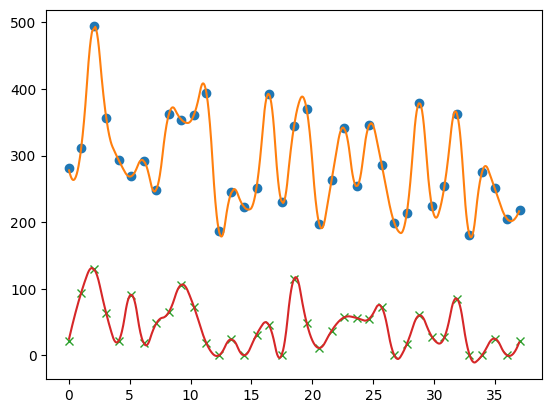

SHAPES:
X_train.shape, y_train.shape (824, 8) (824,)
X_test.shape, y_test.shape (100, 8) (100,)
None
None
X_train.shape (824, 8)
y_train.shape (824,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[236.60519633 355.15542471 419.67424686 302.85735099 282.74855875
 360.76783865 230.79235234 282.50466653 310.63065162 385.64146434
 304.54747188 267.87705722 217.08965811 269.79092875 218.38446169
 273.51685088 348.96881013 215.3657648  399.28024355 334.78672909
 228.27507519 283.34121717 308.44090363 291.43126445 308.04671481
 327.3809888  226.60623097 222.43908298 332.93224274 263.56701945
 240.91125957 386.32388629 198.55699429 239.34527763 281.08083049
 238.91773302 263.77677081]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (824, 8)
y_train.shape (824,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[220.05943655 329.31448652 474.88490956 362.75486737 294.18634189
 329.07285405 283.83176401 344.40122922 360.48202089 346.87556668
 3

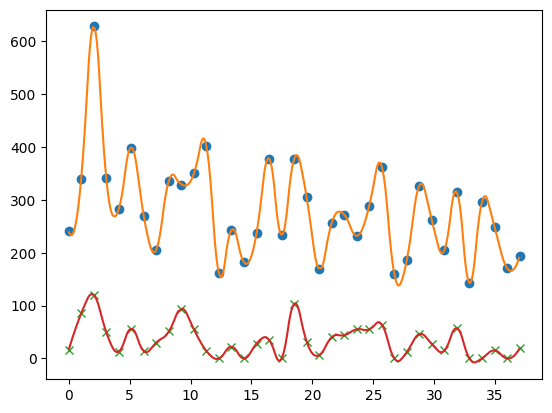

SHAPES:
X_train.shape, y_train.shape (829, 8) (829,)
X_test.shape, y_test.shape (100, 8) (100,)
None
None
X_train.shape (829, 8)
y_train.shape (829,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[222.28096524 369.56495907 483.77071405 318.72739745 264.52077953
 336.22711009 238.01537348 271.75026276 316.63701438 405.2712123
 308.26682542 223.34623086 205.78230313 245.40295233 187.05667564
 269.26437798 283.56005874 192.38399963 441.8823861  292.13869512
 194.70602184 314.5126766  300.28903695 310.23927832 303.4953335
 322.65962729 185.51470183 226.09929191 326.21365773 245.86061763
 216.54693633 334.48425979 202.82668571 226.81211359 255.23819795
 192.99246541 258.34136268]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (829, 8)
y_train.shape (829,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[224.43637627 349.27916884 613.26097871 344.23522358 283.61366642
 395.41874605 233.57220354 205.48532121 332.08329039 329.7908353
 327.

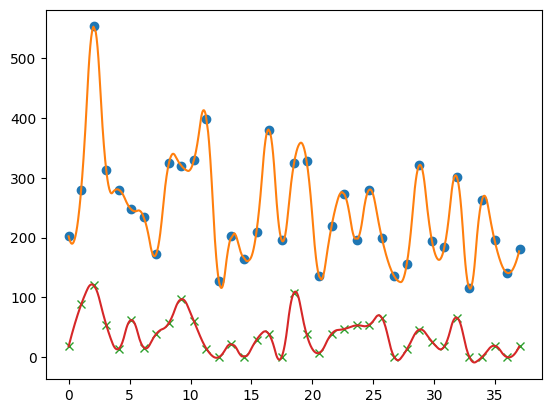

SHAPES:
X_train.shape, y_train.shape (803, 8) (803,)
X_test.shape, y_test.shape (100, 8) (100,)
None
None
X_train.shape (803, 8)
y_train.shape (803,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[194.60776282 326.8829009  387.92356886 261.38195482 221.19899791
 280.31941095 199.48624815 238.34708099 274.03741088 351.56028786
 271.88650619 208.9452708  179.29491302 222.33773404 171.7927497
 236.42166415 264.80177457 178.80263914 367.22527927 261.9203401
 174.19345415 260.80744229 267.75856968 267.80699949 269.2277001
 289.59682209 182.72033751 196.75199017 269.26007248 236.47420779
 197.79720561 315.06438708 179.04969877 199.265171   224.31225698
 197.62467297 213.7191706 ]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (803, 8)
y_train.shape (803,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[182.57259459 312.1303425  528.49996672 322.00742558 279.02979998
 248.12877194 211.92686509 210.65952081 322.42122273 318.68301378
 322.

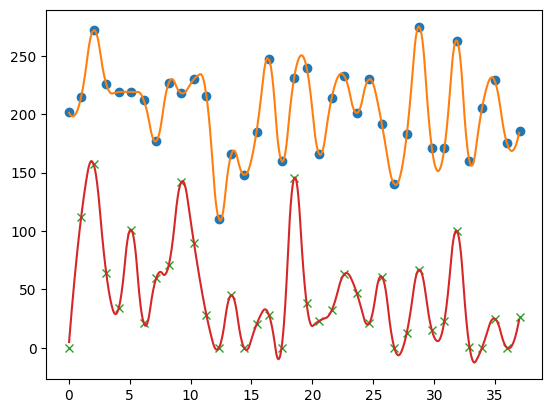

SHAPES:
X_train.shape, y_train.shape (832, 8) (832,)
X_test.shape, y_test.shape (100, 8) (100,)
None
None
X_train.shape (832, 8)
y_train.shape (832,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[171.66035971 232.37882036 270.22976625 209.30912137 215.29212849
 240.72413444 170.50809131 196.99657001 212.31326934 235.34120794
 201.54159628 199.02872278 174.52257006 199.2484734  165.27160859
 188.26988854 205.85662904 168.60640714 254.81314033 223.76982648
 181.39116151 199.90911067 210.06640083 215.67479279 189.9435213
 189.21955976 176.01579686 179.74536516 237.97658854 185.77924332
 178.92001166 256.34787267 181.97717248 219.33175142 203.26674508
 192.15298461 203.89053712]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (832, 8)
y_train.shape (832,)
X_test.shape (100, 8)
y_test.shape (100,)
Estimation
[163.56677351 211.88783611 268.73679323 227.75227049 219.00104117
 222.13367612 210.37970508 179.95192824 225.91612815 218.42057858
 22

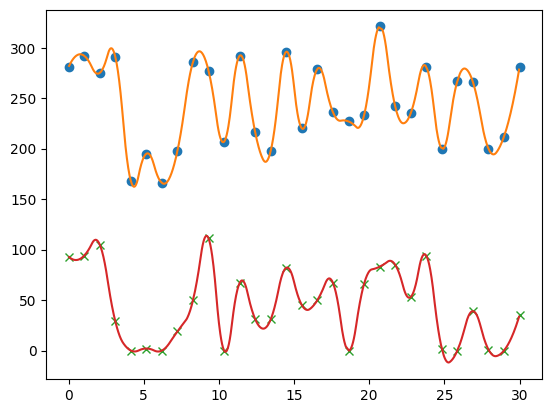

SHAPES:
X_train.shape, y_train.shape (831, 14) (831,)
X_test.shape, y_test.shape (100, 14) (100,)
None
None
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[272.61740571 276.61764289 278.99779579 239.60397573 210.5550415
 229.52045437 215.6831849  230.35565284 249.51280516 279.44919095
 219.00780012 261.53966018 230.5197772  241.44142594 261.17982568
 243.99678932 247.9576021  251.92678848 215.41261821 248.96433197
 270.87778449 263.45888319 247.10373606 266.05674006 223.74964561
 226.03141047 244.477255   217.21836092 215.01517737 233.27725586]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[282.70121397 314.65045093 274.83674675 258.65301423 227.34786429
 193.80400855 219.44330886 207.62064635 259.92409069 264.31179317
 204.50975275 288.16170835 216.5442168  215.55568949 280.08324777
 250.64618733 277.214549

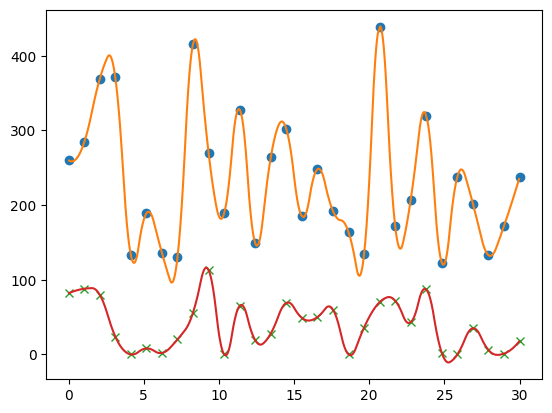

SHAPES:
X_train.shape, y_train.shape (832, 14) (832,)
X_test.shape, y_test.shape (100, 14) (100,)
None
None
X_train.shape (832, 14)
y_train.shape (832,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[265.13338907 296.74631632 276.86332353 293.35498593 155.93356776
 249.81004159 186.29428045 201.58481768 271.03417486 285.64088629
 174.34485786 291.65986519 176.44846556 270.31394566 217.14820953
 227.60914965 260.85942729 213.58096705 167.69110898 196.39139583
 307.23175263 248.83567373 205.84760627 250.31157968 189.79723464
 243.89174336 232.20120893 189.35768682 165.57331922 203.12112481]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (832, 14)
y_train.shape (832,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[315.22867473 304.19772096 345.94162006 291.36274299 167.56266673
 188.56471713 109.01780221 128.63002186 226.04691511 247.96953193
 139.77548248 319.68628056 150.24018394 287.63028293 229.33556704
 151.05452149 247.38325

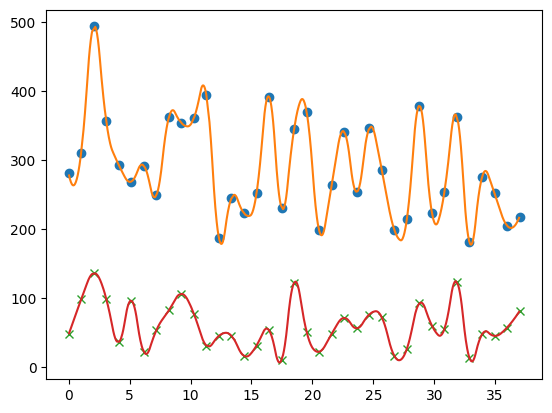

SHAPES:
X_train.shape, y_train.shape (788, 5) (788,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (788, 5)
y_train.shape (788,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[233.68385068 337.06585901 405.0116119  330.89419384 288.73076634
 347.64050656 202.23372926 268.55985786 316.24500201 368.3117027
 285.82554079 275.03122101 257.95754048 273.43076261 210.94334823
 261.96473967 344.1307199  197.54944261 393.6833518  327.51506069
 209.00566542 284.15918861 297.12714726 266.03041434 320.8676997
 291.90177308 244.55249831 210.64110454 354.21031503 271.42008677
 244.9300274  424.66118648 192.87868629 271.19013723 282.24159982
 303.22275346 326.71298281]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (788, 5)
y_train.shape (788,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[223.02077102 324.63984447 469.34495264 368.30553613 291.08378456
 331.3528891  287.16708215 377.39122444 353.64077799 344.24819453
 362

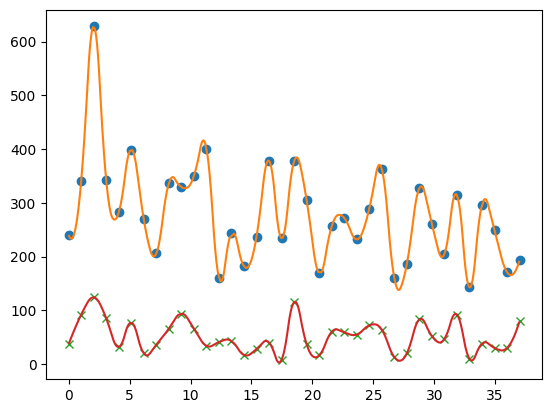

SHAPES:
X_train.shape, y_train.shape (799, 5) (799,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (799, 5)
y_train.shape (799,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[236.97931159 349.64135582 472.7602839  364.38179508 269.80375286
 353.39149807 231.9382505  255.16434789 314.97236488 369.71910867
 301.1547168  219.45464421 253.448938   254.82910947 183.58000388
 238.03769167 248.26733432 174.4247431  442.10987458 268.81941021
 176.50311784 327.8504449  290.99335657 282.66865159 300.75115506
 293.12234522 166.24653167 210.94589269 369.95985897 255.73096329
 251.14092345 370.00064975 182.78029859 280.10009592 259.08133356
 209.3197654  338.67425853]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (799, 5)
y_train.shape (799,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[213.62808877 344.9041409  609.75318687 355.33844704 279.93725437
 393.39897614 242.22379214 203.95221978 326.72407986 329.7908353
 31

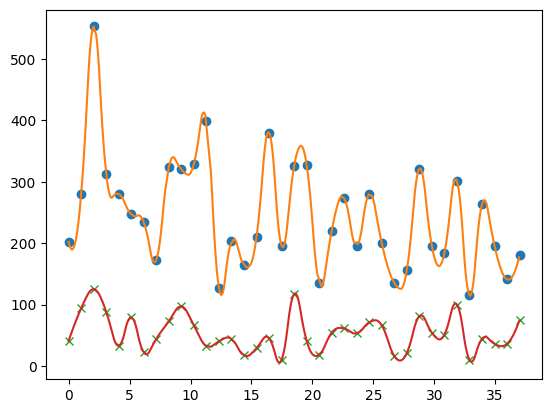

SHAPES:
X_train.shape, y_train.shape (760, 5) (760,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (760, 5)
y_train.shape (760,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[179.53406544 321.5882665  396.70163672 300.80787284 227.12341107
 284.54887894 151.20947264 214.24033511 287.28878988 348.25745454
 252.72193061 214.5387999  216.13646976 221.20317588 149.94647464
 196.62215464 256.80565701 135.66885662 388.06322062 251.19585848
 143.61931887 271.1034357  276.46876806 232.11254784 283.8780074
 252.21761015 180.650693   158.76496042 314.09019395 254.53487008
 206.57874845 387.85242003 159.60464526 234.10349658 221.31559761
 233.28348515 295.37950449]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (760, 5)
y_train.shape (760,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[183.66260319 299.08454966 532.89389957 346.06841477 267.49907156
 267.75784538 211.4847424  307.37143117 321.45837082 317.25562725
 32

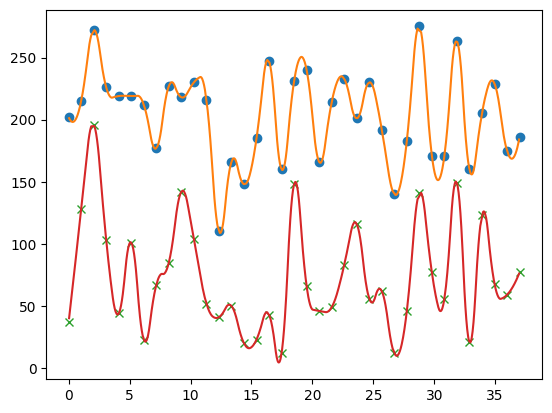

SHAPES:
X_train.shape, y_train.shape (803, 5) (803,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (803, 5)
y_train.shape (803,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[159.92639378 234.57687233 277.02836458 218.59369281 209.9584297
 239.80409989 165.486176   203.63793315 219.99323624 233.85848828
 197.67363761 206.35467061 173.59173622 190.18545631 156.85637926
 191.06523198 214.43163581 146.30765215 261.12453417 229.0295594
 172.16609146 204.21162745 195.16703078 222.29737225 201.61177707
 178.19898664 175.39642819 174.80398279 238.24786479 177.71760368
 165.52512602 274.36501257 178.83559972 215.59316796 196.01176362
 194.43959932 206.29468216]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (803, 5)
y_train.shape (803,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[158.8173674  209.81960173 268.20806625 220.57533526 219.03092758
 219.01357564 211.81058527 193.47284706 226.86430637 218.28865465
 229

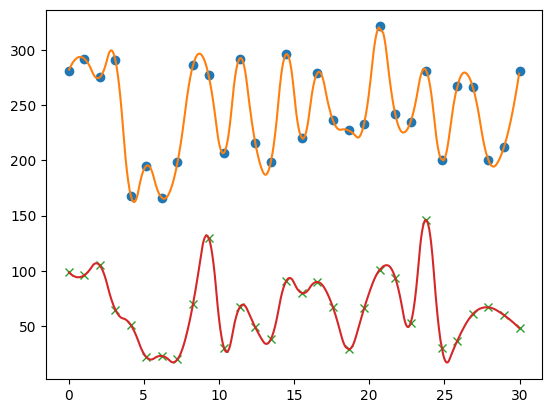

SHAPES:
X_train.shape, y_train.shape (808, 7) (808,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (808, 7)
y_train.shape (808,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[262.64885118 268.16099434 263.53292822 236.16120455 225.16314413
 229.1522139  208.16775985 213.60187904 242.59502335 288.13127502
 226.14407289 254.92236411 222.16032072 221.14935165 266.40345525
 252.67361805 247.50976653 243.42536955 219.93667397 233.637301
 273.97160823 263.86855831 237.28221217 290.29538579 232.30187883
 244.28125912 249.74136179 244.99904303 244.15262451 232.78358773]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (808, 7)
y_train.shape (808,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[279.13866248 302.47446258 266.44665273 257.03282334 221.28670724
 204.24031048 221.56495233 210.6893058  264.60458818 265.56267125
 210.6893058  295.37226867 221.13030032 213.46326297 263.27311106
 292.42446256 277.22171879 227.

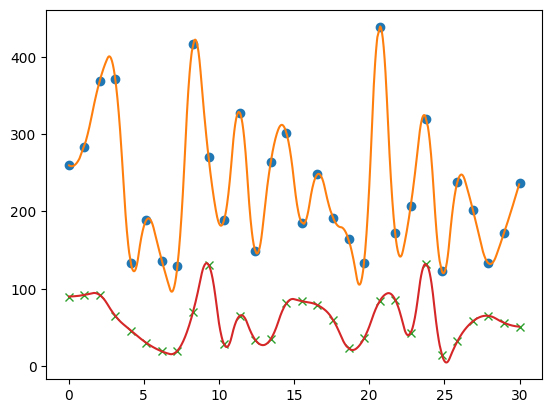

SHAPES:
X_train.shape, y_train.shape (801, 7) (801,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[243.1241076  280.15276368 250.53865437 226.56396284 192.06020107
 256.88410178 164.99472152 185.46717867 266.85993415 324.19599668
 213.42731818 288.16110426 185.95238451 212.32278258 265.0176761
 249.94196535 207.40924158 224.99836468 179.08416064 189.09362327
 314.31995219 286.65140792 199.35676296 321.32248897 178.54697992
 251.47020625 239.51461768 220.82988781 215.41487867 248.18808167]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[315.22867473 281.60692333 321.66269137 155.60558669 143.22189487
 185.15668755 120.67699242 134.66621974 311.1265956  250.57528112
 274.85111217 312.92348527 175.16706137 192.06881472 144.83845529
 141.87864501 244.75206229 209

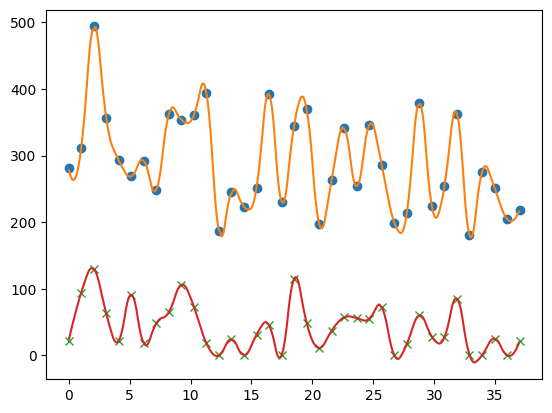

SHAPES:
X_train.shape, y_train.shape (797, 5) (797,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[238.77435624 357.81963755 425.49123634 293.33150535 282.83015942
 361.95568088 232.56529199 280.15161725 308.96179341 388.6882817
 312.18088973 247.67342368 229.98654079 267.8338275  221.0589166
 264.79226812 329.32889761 243.81002864 399.17648906 330.76938921
 231.91578727 281.80871589 331.53975453 295.56211868 295.37626004
 328.1103914  200.29666004 240.86537598 335.51123886 269.87024504
 245.81591018 363.2842183  193.00491132 242.73783774 274.30524526
 232.80613301 252.80130834]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[207.92280749 300.53363043 460.13280316 368.67277795 294.32092119
 298.85760104 283.83176401 306.90381862 357.26268526 359.33534
 358.66

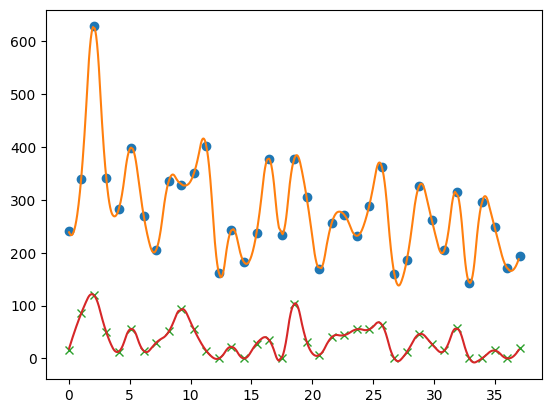

SHAPES:
X_train.shape, y_train.shape (797, 5) (797,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[203.61143641 374.86367329 483.95453232 299.18609824 275.18934596
 335.53677911 217.37507329 264.92533431 315.65047438 422.25387078
 303.44241502 228.27982561 203.8604249  243.02434706 186.84005734
 272.91800378 304.64731291 202.1427326  442.49285559 304.25697152
 188.11368374 314.97078598 310.45838564 307.24063563 299.22532303
 320.76684743 184.47597429 229.17639798 330.3722306  260.97009451
 198.1266913  314.8837711  210.43564996 222.88953753 251.49991581
 187.7316942  255.60148296]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[201.46754396 339.41459935 613.26097871 345.24128745 287.24100447
 374.60505084 254.07372929 206.26010032 350.90719318 330.78149426
 3

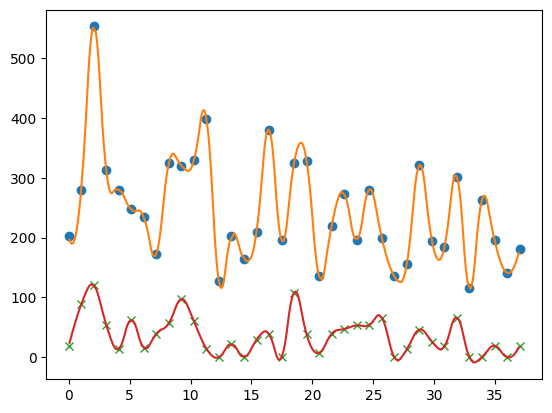

SHAPES:
X_train.shape, y_train.shape (769, 5) (769,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (769, 5)
y_train.shape (769,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[177.28957122 329.44709355 404.03429198 240.71794812 239.34857751
 288.89062771 179.17901646 224.26865561 262.23326911 366.96702239
 261.56889523 201.0757232  175.21288987 223.02945044 162.06804892
 239.37334655 289.23730607 195.06262878 376.28233718 275.92207139
 146.92216893 265.36775624 274.3941892  261.36279656 261.45411116
 289.60747564 156.21614435 199.86207349 287.04686765 262.89665517
 181.97674329 326.40096588 167.44441159 219.03157651 223.67665437
 216.21004503 210.82732812]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (769, 5)
y_train.shape (769,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[196.19945076 288.52054518 516.87709368 322.28320652 279.49679485
 251.21579848 220.42808403 205.84491892 313.12934173 319.41898832
 3

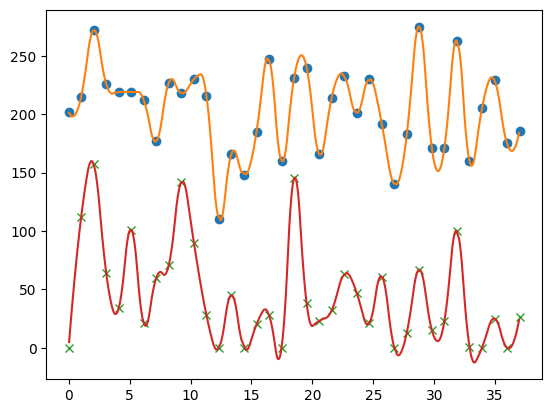

SHAPES:
X_train.shape, y_train.shape (790, 5) (790,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (790, 5)
y_train.shape (790,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[176.25018712 234.76234462 266.77890594 196.01164237 226.22743736
 251.90108431 171.70163128 197.76656037 208.02376026 240.82629865
 204.65523921 192.17947075 178.61891032 207.92563355 172.14678484
 188.92114801 206.33722448 192.13513831 259.93198422 223.07173483
 189.11524655 196.086312   231.04055626 195.4589434  176.83941102
 198.87742896 171.75251996 184.23232664 232.76342756 189.98862516
 185.4236748  240.28688991 186.34585659 201.97020325 200.20682425
 185.02560557 200.74004895]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (790, 5)
y_train.shape (790,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[159.23511178 223.25110662 268.65492891 228.01991616 218.99519853
 219.01357564 211.81058527 180.65069845 227.15404139 218.63739063
 2

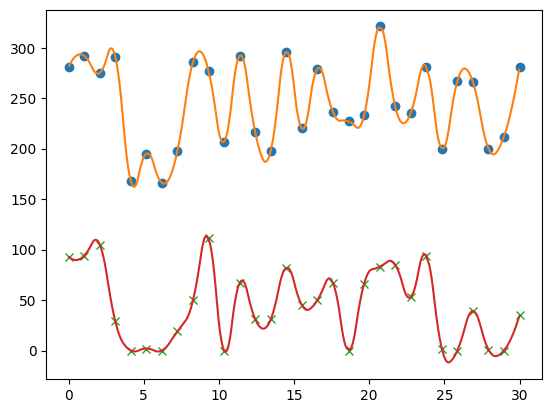

SHAPES:
X_train.shape, y_train.shape (798, 7) (798,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (798, 7)
y_train.shape (798,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[294.03915598 295.9352944  298.58028129 244.18164932 200.64893064
 235.61134448 199.32816727 209.46790193 268.88538244 292.54621439
 207.17457401 280.14658352 214.91660101 228.61113966 281.63973764
 233.72952956 257.22479654 237.01078819 188.44816947 238.11105362
 280.07124135 277.16254355 247.83833419 261.65837466 226.16562459
 240.07158437 239.5231688  200.26425111 204.0394687  262.21823319]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (798, 7)
y_train.shape (798,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[288.38061739 292.53827358 275.92450087 290.39361987 180.46059182
 194.00198746 166.18133327 202.90238075 284.69822305 275.87070898
 208.64715516 288.94679343 217.45500747 199.773904   293.15022707
 221.65881542 279.01772963 23

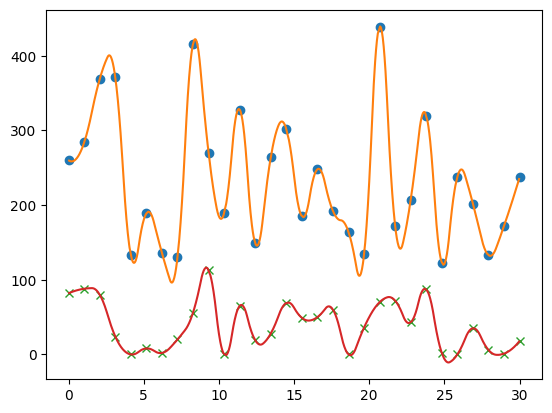

SHAPES:
X_train.shape, y_train.shape (801, 7) (801,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[289.3227271  353.08255516 297.09501656 319.9149932  122.67672209
 253.36591582 160.74454388 170.167362   322.54274127 332.97651258
 149.97225937 340.36598079 149.49040134 260.92729912 241.84895566
 218.16729657 272.73824777 188.00640771 111.21989096 172.80727926
 360.52101859 280.37072161 218.03098553 257.30975739 178.12079951
 251.86882569 178.54666134 145.26918384 118.76192319 221.02374664]
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[319.89433615 269.32750429 367.73656635 367.94903182 154.72904575
 189.52259706 131.98080116 118.79134725 414.11590647 285.06997827
 217.34708102 325.75950315 149.22687058 260.56535033 294.34995251
 190.71845259 246.4742998  18

In [29]:
experiments = [
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
    compare_models(2024, pr_group=1, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
    compare_models(2024, pr_group=2, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
]

#### Код записи результатов экспериментов в файл experiment.csv

In [30]:
exp_results = []
for ds in experiments:
    #print(ds)
    for k, v in ds.items():
        exp_results.extend(v)
        
exp_results.sort(
    key=lambda row: (row['Dataset_name'], -row['R2'])
)
write_experiment_csv(2024, exp_results, exp_fieldnames, 'experiment')